In [2]:
import pandas as pd
import numpy as np
import os 
import re
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import string

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.style.use('bmh')

%pprint # turn pretty printing off 

Pretty printing has been turned OFF


# Missing data imputation

In [ ]:
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time

os.chdir('../data/malay_mail')

In [3]:
files = [file for file in os.listdir() if ('malaysia' in file) & ('complete' in file)]
print(len(files))
print(files[0:5])

df = pd.DataFrame()
for file in files:
    df = pd.concat([df, pd.read_csv(file)])
    
print(df.shape)
df.reset_index(inplace=True, drop=True)
df.head()

54
['malaysia_2017_April_complete.csv', 'malaysia_2017_August_complete.csv', 'malaysia_2017_December_complete.csv', 'malaysia_2017_February_complete.csv', 'malaysia_2017_January_complete.csv']
(90923, 5)


,year_month,title,link,time,article
0,2017_April,"Three killed, border policeman injured in Buki...",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 10:16 PM MYT",BUKIT KAYU HITAM April 30 — Three people were...
1,2017_April,Motion urging Guan Eng to take leave as chief ...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:28 PM MYT","TASEK GELUGOR, April 30 — The motion urging L..."
2,2017_April,"Maybe Hadi is the confused one, says Muhyddin",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:13 PM MYT","PETALING JAYA, April 30 — PAS president Datuk..."
3,2017_April,Azmin incredulous PAS willing to split with PK...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:24 PM MYT","KUALA LUMPUR, April 30 — Selangor Mentri Besa..."
4,2017_April,Indian national with 10kg ketamine hidden betw...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:15 PM MYT","KUALA TERENGGANU, April 30 — An Indian nation..."


In [31]:
df.isna().sum()

year_month    0
title         0
link          0
time          0
article       0
date          0
dtype: int64

In [29]:
miss_ind = df.loc[df['article'].isna(), :].index
miss_ind

Int64Index([ 1077,  2197,  2438,  2472,  3509,  4120,  4753,  6096,  6451,
             7207,  7569,  8786, 10537, 12342, 14758, 23487, 23596, 23646,
            24839, 25784, 26506, 28494, 32069, 35816, 36726, 37462, 37619,
            39798, 44316, 46756, 47060, 47522, 48669, 49069, 58503, 59364,
            59456, 59808, 59904, 60263, 61443, 63305, 64480, 65308, 65409,
            67580, 68589, 68995, 68998, 69082, 69404, 69413, 71291, 72136,
            73764, 75127, 75855, 80162, 80616, 81495, 82596, 82637, 83106,
            84176, 85535, 86811, 89326, 89728],
           dtype='int64')

In [30]:
os.chdir('../../')
start = time.time()
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

# Create lists to store information of articles
timestamps = []
articles = []

# Open a browser
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")
driver = webdriver.Chrome(options=options)

# Set the time a page can take to load
driver.set_page_load_timeout(15) 

def check_exists_by_xpath(xpath, timeout=2):
    '''Return a boolean that indicates the presence of an element given a xpath.'''
    try:
        WebDriverWait(driver, timeout=timeout).until(
            EC.presence_of_element_located((By.XPATH, xpath)))
        return True
    except:
        return False

# Collect information for each article given a link 
for link in df.loc[miss_ind, 'link']:  
    try:
        driver.get(link)
    except TimeoutException: 
        # Stop pending requests when taking longer than 20s to load 
        print('Maximum time exceeded:', link)

    # Click the consent button for collection of personal data if present
    if check_exists_by_xpath("//button[@class='fc-button fc-cta-consent fc-primary-button']"):
        consent_button = driver.find_element_by_xpath("//button[@class='fc-button fc-cta-consent fc-primary-button']")
        actions = ActionChains(driver).click(consent_button)
        actions.perform()

    try:
        # Collect timestamp 
        timestamps.append(driver.find_element_by_xpath('//div[@class="byline"]/p').text)

        # Collect article 
        article = WebDriverWait(driver, 2).until(EC.presence_of_all_elements_located((By.XPATH, "//article/p")))
        article = ' '.join([text.text for text in article])
        articles.append(article)
    except:
        timestamps.append(None)
        articles.append(None)

# Close the browser
driver.quit()

df.loc[miss_ind, 'time'] = timestamps
df.loc[miss_ind, 'article'] = articles

2021-08-04 02:58:02


In [32]:
df.to_csv('data/data_complete.csv', index=False, encoding='utf-8-sig')

# Variables cleaning

In [4]:
df = pd.read_csv('data/data_complete.csv')
print(df.shape)
df.head()

(90923, 6)


,year_month,title,link,time,article,date
0,2017_April,"Three killed, border policeman injured in Buki...",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 10:16 PM MYT",BUKIT KAYU HITAM April 30 — Three people were...,2017-04-01
1,2017_April,Motion urging Guan Eng to take leave as chief ...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:28 PM MYT","TASEK GELUGOR, April 30 — The motion urging L...",2017-04-01
2,2017_April,"Maybe Hadi is the confused one, says Muhyddin",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:13 PM MYT","PETALING JAYA, April 30 — PAS president Datuk...",2017-04-01
3,2017_April,Azmin incredulous PAS willing to split with PK...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:24 PM MYT","KUALA LUMPUR, April 30 — Selangor Mentri Besa...",2017-04-01
4,2017_April,Indian national with 10kg ketamine hidden betw...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:15 PM MYT","KUALA TERENGGANU, April 30 — An Indian nation...",2017-04-01


In [5]:
# Drop empty articles eg. videos and pictures 
df.dropna(subset=['article'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(90855, 6)

In [6]:
# Convert date from str to datetime 
df['date'] = pd.to_datetime(df.year_month, format='%Y_%B')
df.date.describe(datetime_is_numeric=True)

count                            90855
mean     2019-05-03 12:05:54.234769408
min                2017-01-01 00:00:00
25%                2018-05-01 00:00:00
50%                2019-05-01 00:00:00
75%                2020-06-01 00:00:00
max                2021-06-01 00:00:00
Name: date, dtype: object

# Text cleaning

In [46]:
def clean_text(text, unigrams=True, punctuation=True):
    '''Assume text is of type string. Convert text into lowercase.
    Remove stopwords and punctuations. Tokenize text into unigrams/bigrams. 
    
    Args:
        text (str): text to be tokenized.
        unigrams (bool): tokenize text into unigrams if True, bigrams if False.
        punctuation (bool): remove punctuation if True. 
        
    Returns:
        a list of tokens.
    '''
    # Covnvert text into lowercase
    text = text.lower()
    text = text.replace('&amp;', '&').replace('\n', ' ').replace('  ', ' ')
    
    # Remove url(s)  
    text = re.sub('https:\/\/[^\s]+', '', text)
    
    # Remove punctuations
    if punctuation == True:
        punctuations = string.punctuation + '‘’“”...―—––'
        text = ''.join([char for char in text if char not in punctuations])
    
    # Remove number 
    text = re.sub('[0-9]+', '', text)

    if unigrams == True:   
        # Tokenize texts into unigrams
        tokens = text.split()

    else:
        # Tokenize texts into bigrams
        tokens = list(bigrams(text))
        
    return tokens

In [48]:
df['tokens'] = df.article.apply(clean_text)

# Count number of tokens
df['no_tokens'] = df.tokens.apply(lambda text: len(text))
df.head()

,year_month,title,link,time,article,date,tokens,no_tokens
0,2017_April,"Three killed, border policeman injured in Buki...",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 10:16 PM MYT",BUKIT KAYU HITAM April 30 — Three people were...,2017-04-01,"[bukit, kayu, hitam, april, three, people, wer...",237
1,2017_April,Motion urging Guan Eng to take leave as chief ...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:28 PM MYT","TASEK GELUGOR, April 30 — The motion urging L...",2017-04-01,"[tasek, gelugor, april, the, motion, urging, l...",217
2,2017_April,"Maybe Hadi is the confused one, says Muhyddin",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:13 PM MYT","PETALING JAYA, April 30 — PAS president Datuk...",2017-04-01,"[petaling, jaya, april, pas, president, datuk,...",185
3,2017_April,Azmin incredulous PAS willing to split with PK...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:24 PM MYT","KUALA LUMPUR, April 30 — Selangor Mentri Besa...",2017-04-01,"[kuala, lumpur, april, selangor, mentri, besar...",204
4,2017_April,Indian national with 10kg ketamine hidden betw...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:15 PM MYT","KUALA TERENGGANU, April 30 — An Indian nation...",2017-04-01,"[kuala, terengganu, april, an, indian, nationa...",221


In [49]:
pickle.dump(df, open("data/data_malaysia_clean", "wb"))

# EDA

In [3]:
df = pickle.load(open("data/data_malaysia_clean", "rb"))
print(df.shape)
df.head()

(90855, 8)


,year_month,title,link,time,article,date,tokens,no_tokens
0,2017_April,"Three killed, border policeman injured in Buki...",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 10:16 PM MYT",BUKIT KAYU HITAM April 30 — Three people were...,2017-04-01,"[bukit, kayu, hitam, april, three, people, wer...",237
1,2017_April,Motion urging Guan Eng to take leave as chief ...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:28 PM MYT","TASEK GELUGOR, April 30 — The motion urging L...",2017-04-01,"[tasek, gelugor, april, the, motion, urging, l...",217
2,2017_April,"Maybe Hadi is the confused one, says Muhyddin",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:13 PM MYT","PETALING JAYA, April 30 — PAS president Datuk...",2017-04-01,"[petaling, jaya, april, pas, president, datuk,...",185
3,2017_April,Azmin incredulous PAS willing to split with PK...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:24 PM MYT","KUALA LUMPUR, April 30 — Selangor Mentri Besa...",2017-04-01,"[kuala, lumpur, april, selangor, mentri, besar...",204
4,2017_April,Indian national with 10kg ketamine hidden betw...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:15 PM MYT","KUALA TERENGGANU, April 30 — An Indian nation...",2017-04-01,"[kuala, terengganu, april, an, indian, nationa...",221


Text(0.5, 1.0, 'Number of English articles per month from 2017 to 2021')

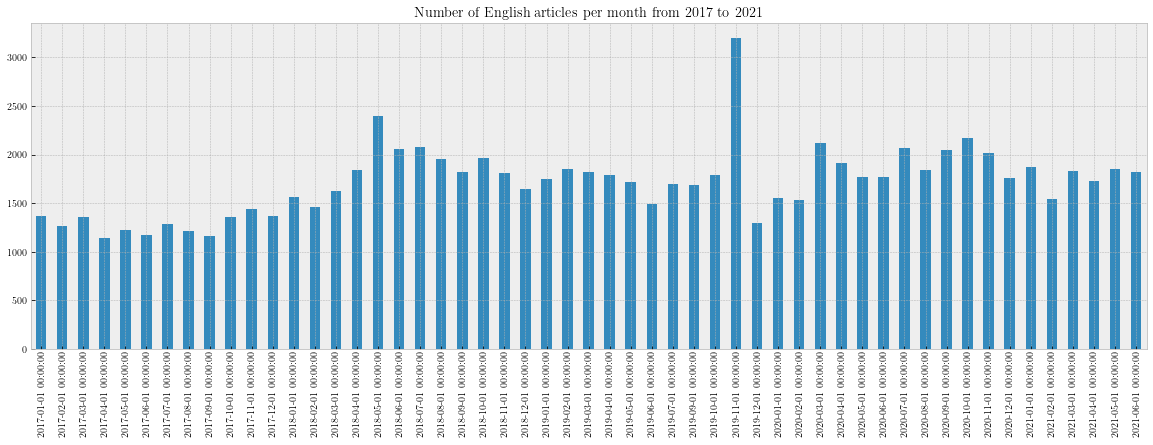

In [3]:
# Number of articles per month 
fig, ax = plt.subplots()
bar = df.date.value_counts().sort_index().plot(kind='bar', figsize=(20, 6))
plt.title('Number of English articles per month from 2017 to 2021')

In [7]:
# Get no. of articles each year
df.date.dt.year.value_counts().sort_index()

2017    15355
2018    22224
2019    20079
2020    22545
2021    10652
Name: date, dtype: int64

In [6]:
# Get no. of tokens each year
print(df.no_tokens.sum())
df.groupby(df.date.dt.year)['no_tokens'].sum()

30032355


date
2017    4744178
2018    7088286
2019    6812567
2020    7661853
2021    3725471
Name: no_tokens, dtype: int64

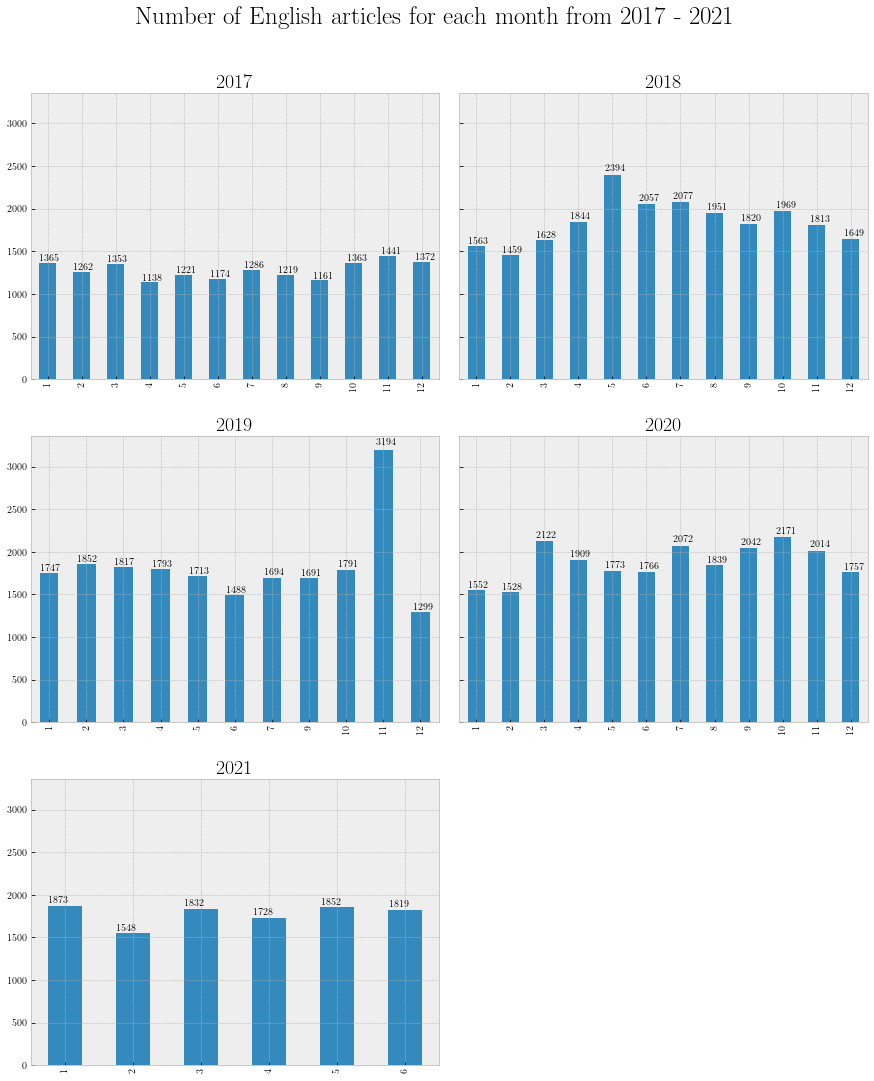

In [8]:
# Plot no. of articles per month
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
title = 'Number of English articles for each month from 2017 - 2021'
years = df.date.dt.year.unique()

for idx in range(len(axes)):
    ax = axes[idx]
    if idx <= len(years)-1:
        year = years[idx]
        data = df.loc[df.date.dt.year == year, 'date']
        data.dt.month.value_counts().sort_index().plot(kind='bar', ax=ax)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
        ax.set_title(year, fontdict={'fontsize': 20})
    else:
        ax.set_axis_off()

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.90, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/no_articles_monthly.eps', format='eps')

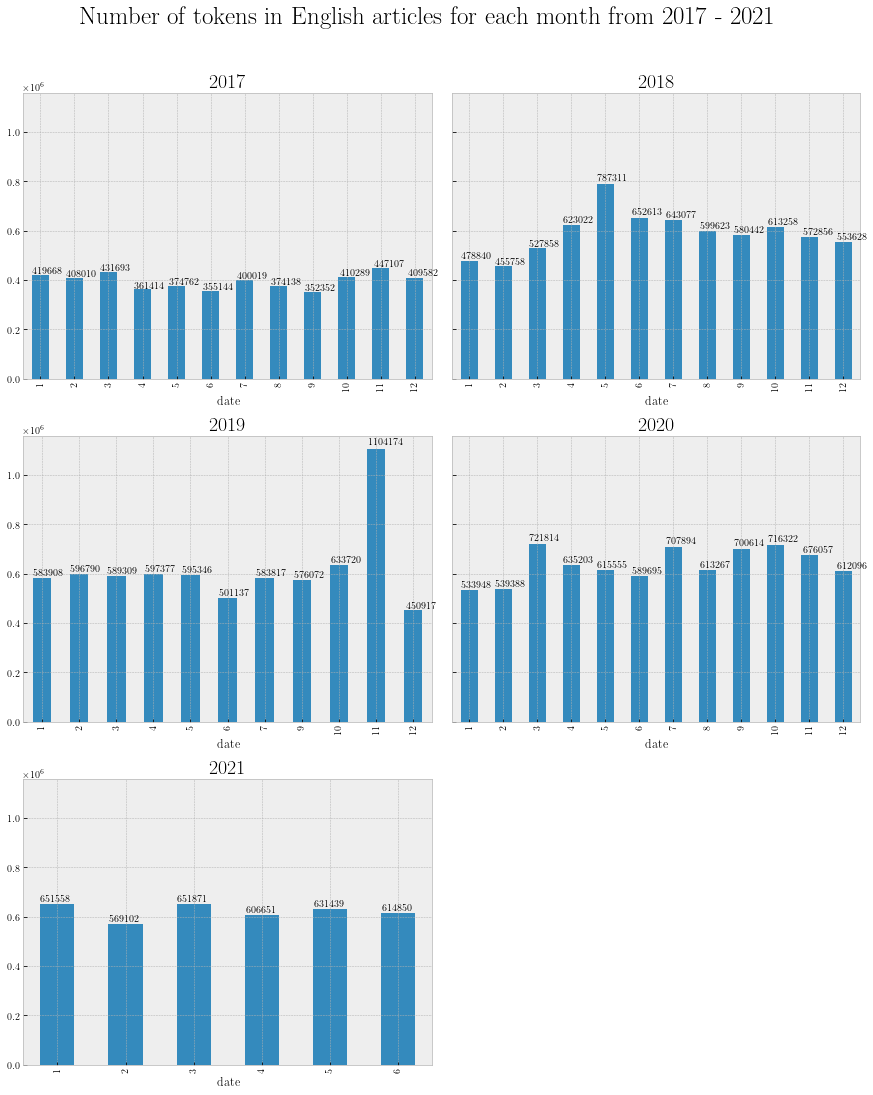

In [11]:
# Plot no. of tokens per month
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
title = 'Number of tokens in English articles for each month from 2017 - 2021'
years = df.date.dt.year.unique()

for idx in range(len(axes)):
    ax = axes[idx]
    if idx <= len(years)-1:
        year = years[idx]
        data = df.loc[df.date.dt.year == year, :]
        data.groupby(data.date.dt.month)['no_tokens'].sum().sort_index().plot(kind='bar', ax=ax)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
        ax.set_title(year, fontdict={'fontsize': 20})
    else:
        ax.set_axis_off()

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.90, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/english_no_tokens_monthly.eps', format='eps')

count    90855.000000
mean       330.552584
std        196.441148
min          0.000000
25%        211.000000
50%        289.000000
75%        390.000000
max       4377.000000
Name: no_tokens, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


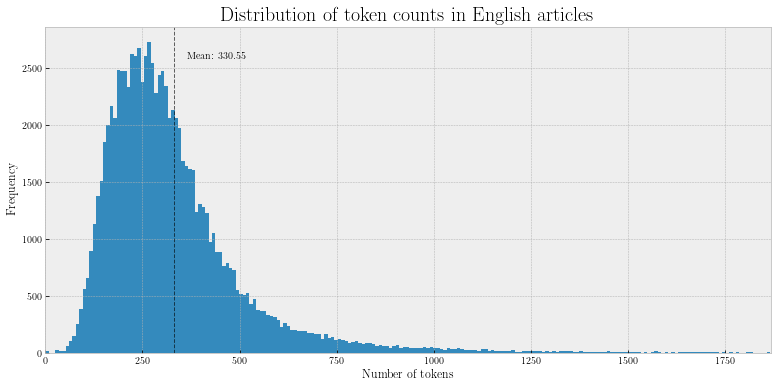

In [4]:
# Plot distribution of tokens number
print(df.no_tokens.describe())
fig, ax = plt.subplots(figsize=(13, 6))
ax = df.no_tokens.plot(kind='hist', bins=500)

plt.axvline(df.no_tokens.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df.no_tokens.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.no_tokens.mean()))

ax.set_xlabel('Number of tokens')
ax.set_title('Distribution of token counts in English articles', fontdict={'fontsize': 20})
ax.set_xlim(0, df.no_tokens.quantile(0.999))
plt.savefig('figs/eng_dist_tokens_counts.eps', format='eps')

count    90855.000000
mean       330.552584
std        196.441148
min          0.000000
25%        211.000000
50%        289.000000
75%        390.000000
max       4377.000000
Name: no_tokens, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


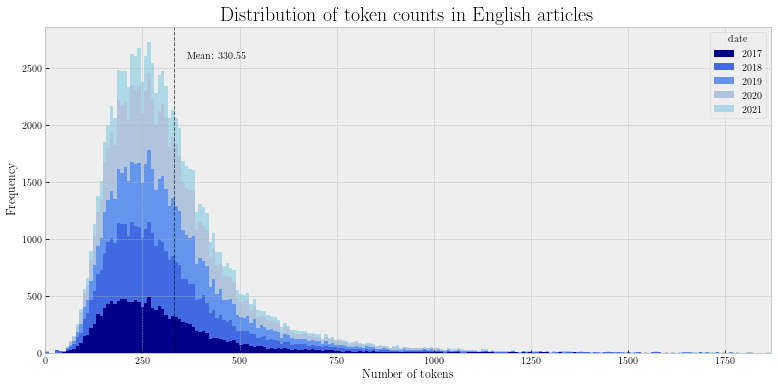

In [5]:
# Plot distribution of tokens number by years 
print(df.no_tokens.describe())

df_hist = df.loc[:, ['no_tokens', 'date']]
df_hist['date'] = df_hist.date.dt.year
df_hist = df_hist.pivot(columns='date', values='no_tokens')
ax = df_hist.plot.hist(stacked=True, bins=500, figsize=(13, 6), color=['darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'lightblue'])

plt.axvline(df.no_tokens.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df.no_tokens.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.no_tokens.mean()))

ax.set_xlabel('Number of tokens')
ax.set_title('Distribution of token counts in English articles', fontdict={'fontsize': 20})
ax.set_xlim(0, df.no_tokens.quantile(0.999))
plt.savefig('figs/eng_dist_tokens_counts_by_year.eps', format='eps')

In [4]:
tokens_len = df.tokens.apply(lambda words: [len(word) for word in words]).explode()
print(tokens_len.describe())

count     30032355
unique          64
top              3
freq       5778313
Name: tokens, dtype: int64


count     30032355
unique          64
top              3
freq       5778313
Name: tokens, dtype: int64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


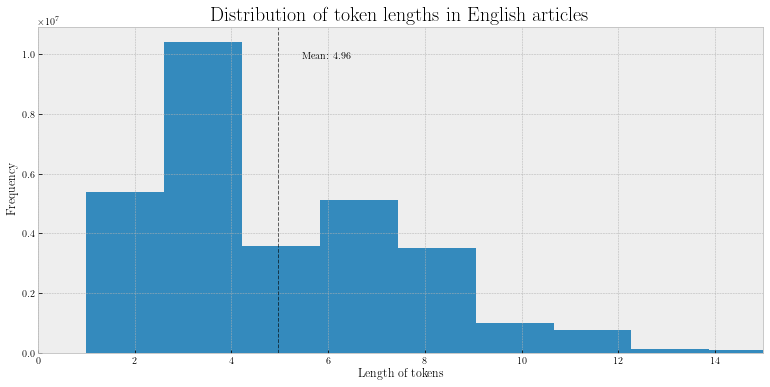

In [6]:
# Plot distribution of tokens length
tokens_len = df.tokens.apply(lambda words: [len(word) for word in words]).explode()
print(tokens_len.describe())

fig, ax = plt.subplots(figsize=(13, 6))
ax = tokens_len.plot(kind='hist', bins=100)

plt.axvline(tokens_len.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(tokens_len.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(tokens_len.mean()))

ax.set_xlabel('Length of tokens')
ax.set_title('Distribution of token lengths in English articles', fontdict={'fontsize': 20})
ax.set_xlim(0, tokens_len.quantile(0.999))
plt.savefig('figs/eng_dist_tokens_lengths.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


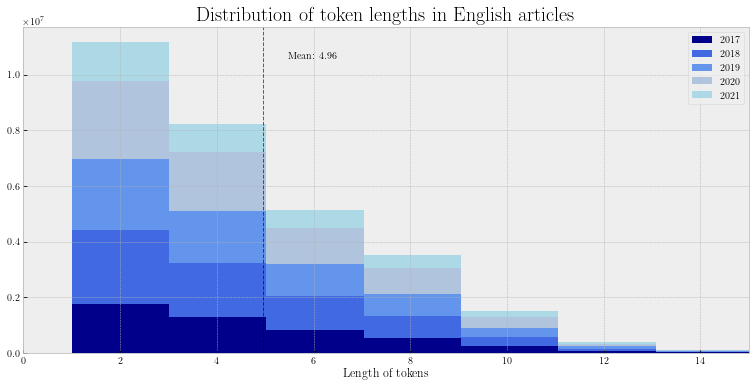

In [10]:
# Plot distribution of tokens length by years
df_hist = df.loc[:, ['tokens', 'date']]
df_hist['tokens'] = df_hist.tokens.apply(lambda words: [len(word) for word in words])
df_hist['date'] = df_hist.date.dt.year
df_hist = df_hist.pivot(columns='date', values='tokens')
df_hist = [df_hist[year].explode() for year in df_hist.columns]

fig, ax = plt.subplots(figsize=(13, 6))
plt.hist(df_hist, stacked=True, bins=80, label=list(range(2017, 2022)), color=['darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'lightblue'])

plt.axvline(tokens_len.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(tokens_len.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(tokens_len.mean()))

ax.legend()
ax.set_xlabel('Length of tokens')
ax.set_title('Distribution of token lengths in English articles', fontdict={'fontsize': 20})
ax.set_xlim(0, tokens_len.quantile(0.999))
plt.savefig('figs/eng_dist_tokens_lengths_by_year.eps', format='eps')

In [ ]:
# Plot most common unigrams

In [ ]:
# Plot most common bigrams